In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import numpy as np

In [4]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from mlp_helper import plot_boundaries_keras
from keras.callbacks import TensorBoard

# Dataset

In [246]:
def get_spiral_dataset(n = 100, noise=0.05, cicles = 2, seed=42):
    np.random.seed(seed)
    N = n//2
    Noise1 = np.random.normal(0, noise, (N, 2))
    Noise2 = np.random.normal(0, noise, (N, 2))
    r = np.linspace(0.1, 1, N)
    theta = np.linspace(0.1,cicles*2*np.pi, N)
    X1 = np.vstack([r*np.cos(theta), r*np.sin(theta)]).T + Noise1# *r.reshape(-1,1)
    X2 = np.vstack([-r*np.cos(theta), -r*np.sin(theta)]).T + Noise2# *r.reshape(-1,1)
    X = np.vstack([X1, X2]) 
    y = np.array([0]*N + [1]*N)
    return X, y
X, y = get_spiral_dataset(n=500)

Text(0, 0.5, '$X_2$')

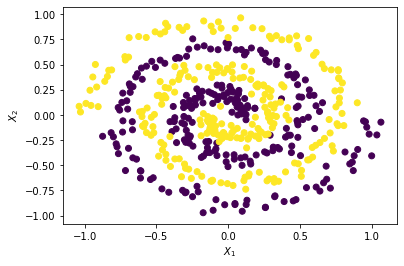

In [247]:
# plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')

In [326]:
def get_sphere_coordinates(X, unwrap=False):
    r = (X[:, 0]**2 + X[:, 1]**2)**0.5
    theta = np.arctan2(X[:, 1], X[:, 0])
    if unwrap:
        theta = np.unwrap(theta)
        
    X_rad = np.vstack([r, theta]).T
    return X_rad

In [327]:
X_sphere = get_sphere_coordinates(X)

Text(0, 0.5, 'theta')

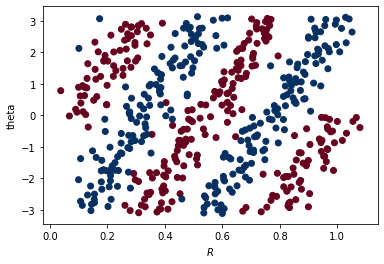

In [328]:
plt.scatter(X_sphere[:,0], X_sphere[:,1], c=y, cmap='RdBu')
plt.xlabel('$R$')
plt.ylabel('theta')

In [330]:
#plt.scatter(X_sphere[:,0]*np.cos(X_sphere[:,1]), X_sphere[:,0]*np.sin(X_sphere[:,1]), c=y)

# Simple model Feature engineering

In [331]:
def get_simple_model(activation='sigmoid', input_dim=2, hidden_units=10, lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units, input_shape=(1,), activation=activation, name='hidden')(X_in)
    X1 = Dense(1, name='Categorical_out', activation='sigmoid')(X)
    model = Model(X_in, X1)
    if compile_model:
        losses = {'Categorical_out': 'binary_crossentropy'}
        metrics = {'Categorical_out': 'accuracy'}
        model.compile(Adam(lr=lr), loss=losses, metrics=metrics)
    return model

In [332]:
simple_model = get_simple_model(lr=0.25, hidden_units=10)
simple_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
Categorical_out (Dense)      (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [333]:
epochs = 500
simple_model.fit(X_sphere, y, verbose=0, epochs=epochs, batch_size=64)

In [334]:
def predict_proba_simple(X):
    X_rad = get_sphere_coordinates(X)
    return simple_model.predict(X_rad)

def score_func_simple(X, y):
    X_rad = get_sphere_coordinates(X)
    return simple_model.evaluate(X_rad, y)[1]

In [335]:
score = score_func_simple(X, y)
print(score)

500/500 [==============================] - 0s 331us/step
0.9860000014305115


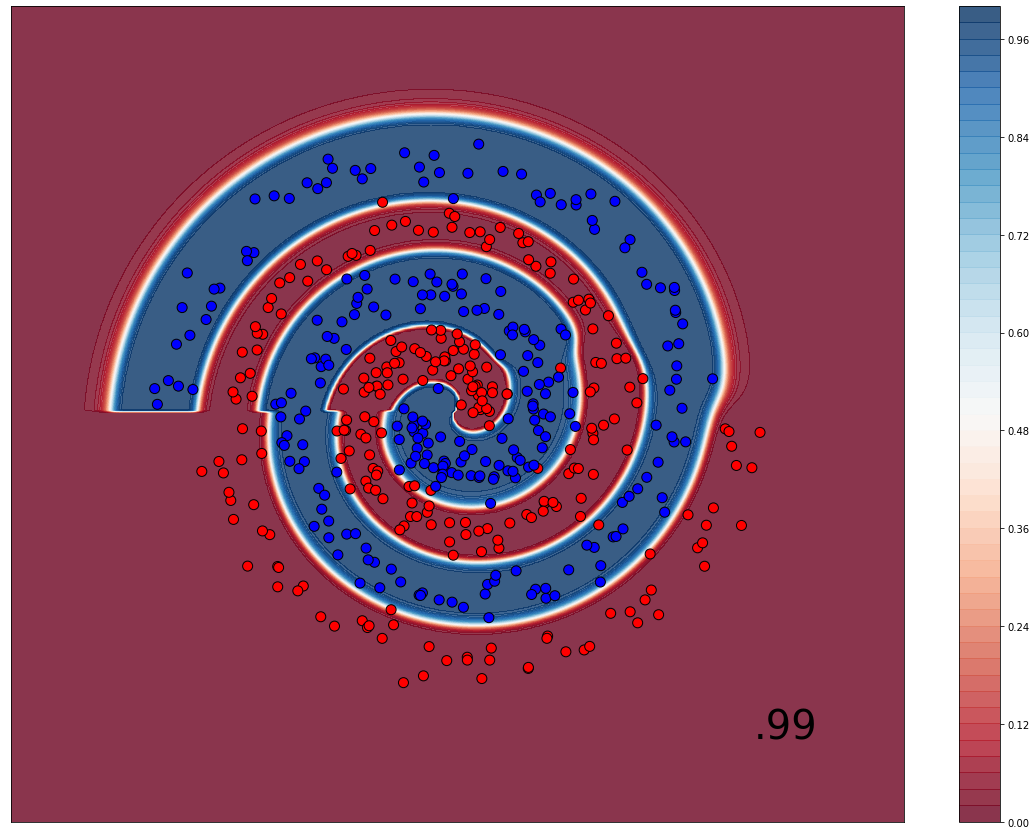

In [336]:
plt.figure(figsize=(20,15))
plot_boundaries_keras(X, y, score, probability_func=predict_proba_simple, h=0.01)

# Multitask Model

In [25]:
def get_two_out_model(activation='sigmoid', input_dim=2, hidden_units=[10], lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units[0], activation=activation, name=f'hidden_1')(X_in)
    for i, units in enumerate(hidden_units[1:]):
        X = Dense(units, activation=activation, name=f'hidden_{i+2}')(X)
    cat_out = Dense(1, name='Categorical_out', activation='sigmoid')(X)
    radius = Dense(1, name='Linear_out_radius', activation='sigmoid')(X)
    theta = Dense(1, name='Linear_out_theta', activation='linear')(X)
    
    model = Model(X_in, [cat_out, radius, theta])
    if compile_model:
        losses = {'Linear_out_radius': 'mse', 'Linear_out_theta': 'mse', 'Categorical_out': 'binary_crossentropy'}
        metrics = {'Linear_out_radius': 'mse', 'Linear_out_theta': 'mse', 'Categorical_out': 'accuracy'}
        loss_weights = {'Linear_out_radius': 1,'Linear_out_theta': 5, 'Categorical_out': 1}
        model.compile(Adam(lr=lr), loss=losses, metrics=metrics, loss_weights=loss_weights)
    return model

In [26]:
lr = 0.1
units = 50
model = get_two_out_model(activation='sigmoid', hidden_units=[units], lr = lr)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 2)            0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 50)           150         Input[0][0]                      
__________________________________________________________________________________________________
Categorical_out (Dense)         (None, 1)            51          hidden_1[0][0]                   
__________________________________________________________________________________________________
Linear_out_radius (Dense)       (None, 1)            51          hidden_1[0][0]                   
____________________________________________________________________________________________

In [875]:
import time

In [876]:
epochs = 2000
tensorboard_cb = TensorBoard(log_dir=f"./logs_{units}_{lr}_{int(time.clock()*1000)}")
model.fit(X, [y, X_rad[:, 0], X_rad[:, 1]/np.pi], verbose=0, epochs=epochs, batch_size=100, callbacks=[tensorboard_cb])

In [864]:
model.evaluate(X, [y, X_rad[:, 0], X_rad[:, 1]/np.pi]), #model.metrics_names

500/500 [==============================] - 1s 2ms/step


([0.02015833777189255,
  0.006981284823268652,
  0.0009110861574299634,
  0.009116632863879204,
  1.0,
  0.000926674110814929,
  0.00925869308412075],)

In [865]:
#model.predict(X)[0]

In [866]:
def predict_proba(X):
    return model.predict(X)[0]

def score_func(X, y):
    
    return model.evaluate(X_rad, y)[4]

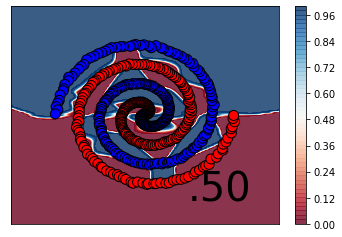

In [867]:
plot_boundaries_keras(X, y, 0.5, probability_func=predict_proba)

In [868]:
y_pred, r_pred, theta_pred = model.predict(X)

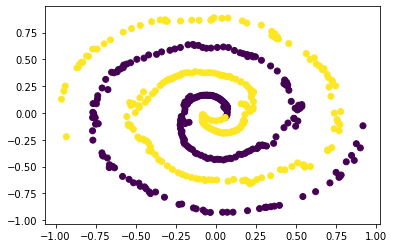

In [869]:
plt.scatter(r_pred*np.cos(theta_pred*np.pi), r_pred*np.sin(theta_pred*np.pi), c=y_pred>0.5)